# Evaluate the cortical distribution of Sensory, Logic, and Motor Parallelism with the Margulies hierarchical gradients

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
sns.set_style("whitegrid")

In [2]:
# Load network
# Using final partition
networkdef = np.loadtxt('../../data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

#### Load in gradient, parallelism, standard decoding maps, and parcellation maps

In [30]:
datadir = '../../data/results/'

rules = ['Motor','Logic','Sensory']
# rules = ['Sensory','Logic','Motor']
ps = {}
decoding = {}

for domain in rules:
    ps[domain] = nib.load(datadir + domain + 'RulePSGroup.dscalar.nii').get_fdata().T
    decoding[domain] = nib.load(datadir + domain + 'RuleDecoding.dscalar.nii').get_fdata().T

# Load in gradient
hierarchical_gradient = nib.load(datadir + '../hcp.gradients.dscalar.nii').get_fdata().T

# Load in glasser atlas
glasser = np.squeeze(nib.load(datadir + '../Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii').get_fdata())


##### Parcellate all data into 360 cortical regions

In [31]:
n_parcels = 360

parcel_gradient = np.zeros((n_parcels,2))
#
parcel_ps = {}
parcel_decoding = {}
for domain in rules:
    parcel_ps[domain] = np.zeros((n_parcels,))
    parcel_decoding[domain] = np.zeros((n_parcels,))
    
for roi in range(n_parcels):
    roi_ind = np.where(glasser==roi+1)[0]
    parcel_gradient[roi,:] = np.mean(hierarchical_gradient[roi_ind,:2],axis=0)*-1
    
    for domain in rules:
        parcel_ps[domain][roi] = np.mean(ps[domain][roi_ind,0],axis=0)
        parcel_decoding[domain][roi] = np.mean(decoding[domain][roi_ind,0],axis=0)
    

#### Tidy data into dataframe

In [32]:
df = {}
df['Gradient1'] = []
df['Gradient2'] = []
df['Parcel'] = []
df['Parallelism'] = []
df['Decoding'] = []
df['Domain'] = []
# df['Depth'] = []

# Normalize all PS and decoding scores for each domain
for domain in rules:
    parcel_ps[domain] = (parcel_ps[domain] - np.min(parcel_ps[domain]))/np.max(parcel_ps[domain])
    parcel_decoding[domain] = (parcel_decoding[domain] - np.min(parcel_decoding[domain]))/np.max(parcel_decoding[domain])
    
for roi in range(n_parcels):
    net = networkdef[roi]
#     if net in sensory_nets: depth = 1
#     if net in association_nets: depth = 2
#     if net in motor_nets: depth = 3
    for domain in rules:
        df['Parcel'].append(roi+1)
        df['Gradient1'].append(parcel_gradient[roi,0])
        df['Gradient2'].append(parcel_gradient[roi,1])
        df['Parallelism'].append(parcel_ps[domain][roi])
        df['Decoding'].append(parcel_decoding[domain][roi])
        df['Domain'].append(domain)
#         df['Depth'].append(depth)

        
df = pd.DataFrame(df)

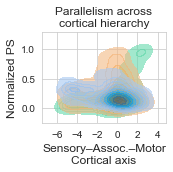

In [38]:
tmp = sns.color_palette('colorblind')
palette = [tmp[2],tmp[1],tmp[0]]
plt.figure(figsize=(2.5,2.5))
ax = sns.kdeplot(x="Gradient2",y="Parallelism",hue="Domain",data=df,shade=True,palette=palette,alpha=.6,legend=False)
plt.title('Parallelism across\ncortical hierarchy',fontsize=12)
# plt.xticks([-5,1],['Input','Output'],fontsize=10,rotation=10)
plt.xticks(np.arange(-6,6,2),fontsize=10)
plt.xlabel('Sensory–Assoc.–Motor\nCortical axis', fontsize=12)
plt.ylabel('Normalized PS',fontsize=12)
plt.yticks(fontsize=10)
# ax.legend_.set_bbox_to_anchor((0, 1.0))
# ax.legend_._set_loc(2)
# plt.setp(ax.get_legend().get_title(), fontsize='0')
# plt.setp(ax.get_legend().get_texts(), fontsize='6')
plt.tight_layout()
plt.savefig('EmpiricalPSGradient.png',dpi=300)
